In [1]:
import config
from config import *
%matplotlib inline

import tools.neural_nets.xrf_autoencoders_32 as autoencoder_32

#removed element ratios in the second part

2022-02-24 13:07:48.010572: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Allocate memory First
import tensorflow as tf
GPU_mem_limit=4.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_mem_limit*1000.0)])

    except RuntimeError as e:
        print(e)        
        

2022-02-24 13:07:48.780607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-24 13:07:49.529394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-24 13:07:49.529469: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-24 13:07:49.529536: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-24 13:07:49.529570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-24 13:07:49.529605: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10

In [3]:
# part 2 

In [4]:
class XRF_image:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
    def load_xrf_data(self, hdf5_string = 'exchange_4'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
        norm_ch = NORM_CH
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
        #         print(chs)



            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
            norm = scaler_val[scaler_names.index(norm_ch)]
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','TFY']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        x_Cu,y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        x_Zn,y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        x_Ca,y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        x_K,y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        x_P,y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        x_S,y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        x_Fe,y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        x_Ni,y_Ni=row['x_axis'], row['y_axis']

                    if e == 'TFY':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        x_TFY,y_TFY=row['x_axis'], row['y_axis']
        #     print('Image shape: ',d.shape)
        
        
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'TFY':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.5*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []

        for idx in range(len(self.regions)):
            self.cell_val_bin=self.regions[idx].image

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.x = np.asarray([0.25*0.25*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             0.25*self.regions[idx].equivalent_diameter, 
             0.25*self.regions[idx].major_axis_length,
             0.25*self.regions[idx].minor_axis_length,
             0.25*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Cu[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_P[idx]-self.Patches_Ni[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx]-self.Patches_Cu[idx])                     
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [5]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img
X1=x.features
X1.shape

(110, 13)

In [6]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin2=x.binary_img
X2=x.features
X2.shape

(41, 13)

In [7]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0003_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin3=x.binary_img
X3=x.features
X3.shape

(43, 13)

In [8]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0012_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin4=x.binary_img
X4=x.features
X4.shape

(53, 13)

In [9]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0014_2018_1w2.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin5=x.binary_img
X5=x.features
X5.shape

(55, 13)

In [10]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0040_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin6=x.binary_img
X6=x.features
X6.shape

(39, 13)

In [11]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0050_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin7=x.binary_img
X7=x.features
X7.shape

(57, 13)

In [12]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0051_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin8=x.binary_img
X8=x.features
X8.shape

(61, 13)

In [13]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0052_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='Cu')
x.extract_cells()
X_bin9=x.binary_img
X9=x.features
X9.shape

(31, 13)

In [14]:
x= XRF_image(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0065_2018_3.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
x.binary_conversion(e='K')
x.extract_cells()
X_bin10=x.binary_img
X10=x.features
X10.shape

(64, 13)

In [15]:
X=np.concatenate((X1,X2,X3,X4,X5,X6,X7,X8,X9,X10))
X_bin=np.concatenate((X_bin1,X_bin2,X_bin3,X_bin4,X_bin5,X_bin6,X_bin7,X_bin8,X_bin9,X_bin10))

In [16]:
print(X.shape)
print(X_bin.shape)

(554, 13)
(554, 32, 32)


In [17]:
def viewer(idx):

    plt.imshow(X_bin[idx]);

    
    plt.title('Binary image')
    plt.colorbar()
#     plt.ylim(-0.5, 5)
#     plt.grid(True)
    plt.show()

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=276, description='idx', max=553), Output()), _dom_classes=('widget-inter…

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_standard = StandardScaler().fit_transform(X)

# reduced_X = PCA(=2).fit(X)

In [19]:
print(X_standard[0])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_standard)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])


print(pca.singular_values_)
print(pca.explained_variance_)
print(pca.components_)

[-1.03765961 -1.69432343 -1.24468001 -1.0746984  -0.79013015 -1.04179638
 -0.61902571 -0.6945955  -0.90463501  0.16871373  0.12428687  0.16871373
  0.42650469]
[54.93414861 43.57970819]
[5.45707176 3.43434171]
[[ 0.41230348  0.31368405  0.41501348  0.3986508   0.32214264  0.40370669
   0.13477547  0.19699636  0.18549451  0.02271229  0.19272202  0.02271229
  -0.06434953]
 [ 0.07806986  0.06488228  0.08592718  0.04543056  0.10614566  0.08438774
  -0.46915421 -0.27023878  0.0064027   0.43642572 -0.2525177   0.43642572
   0.47326959]]


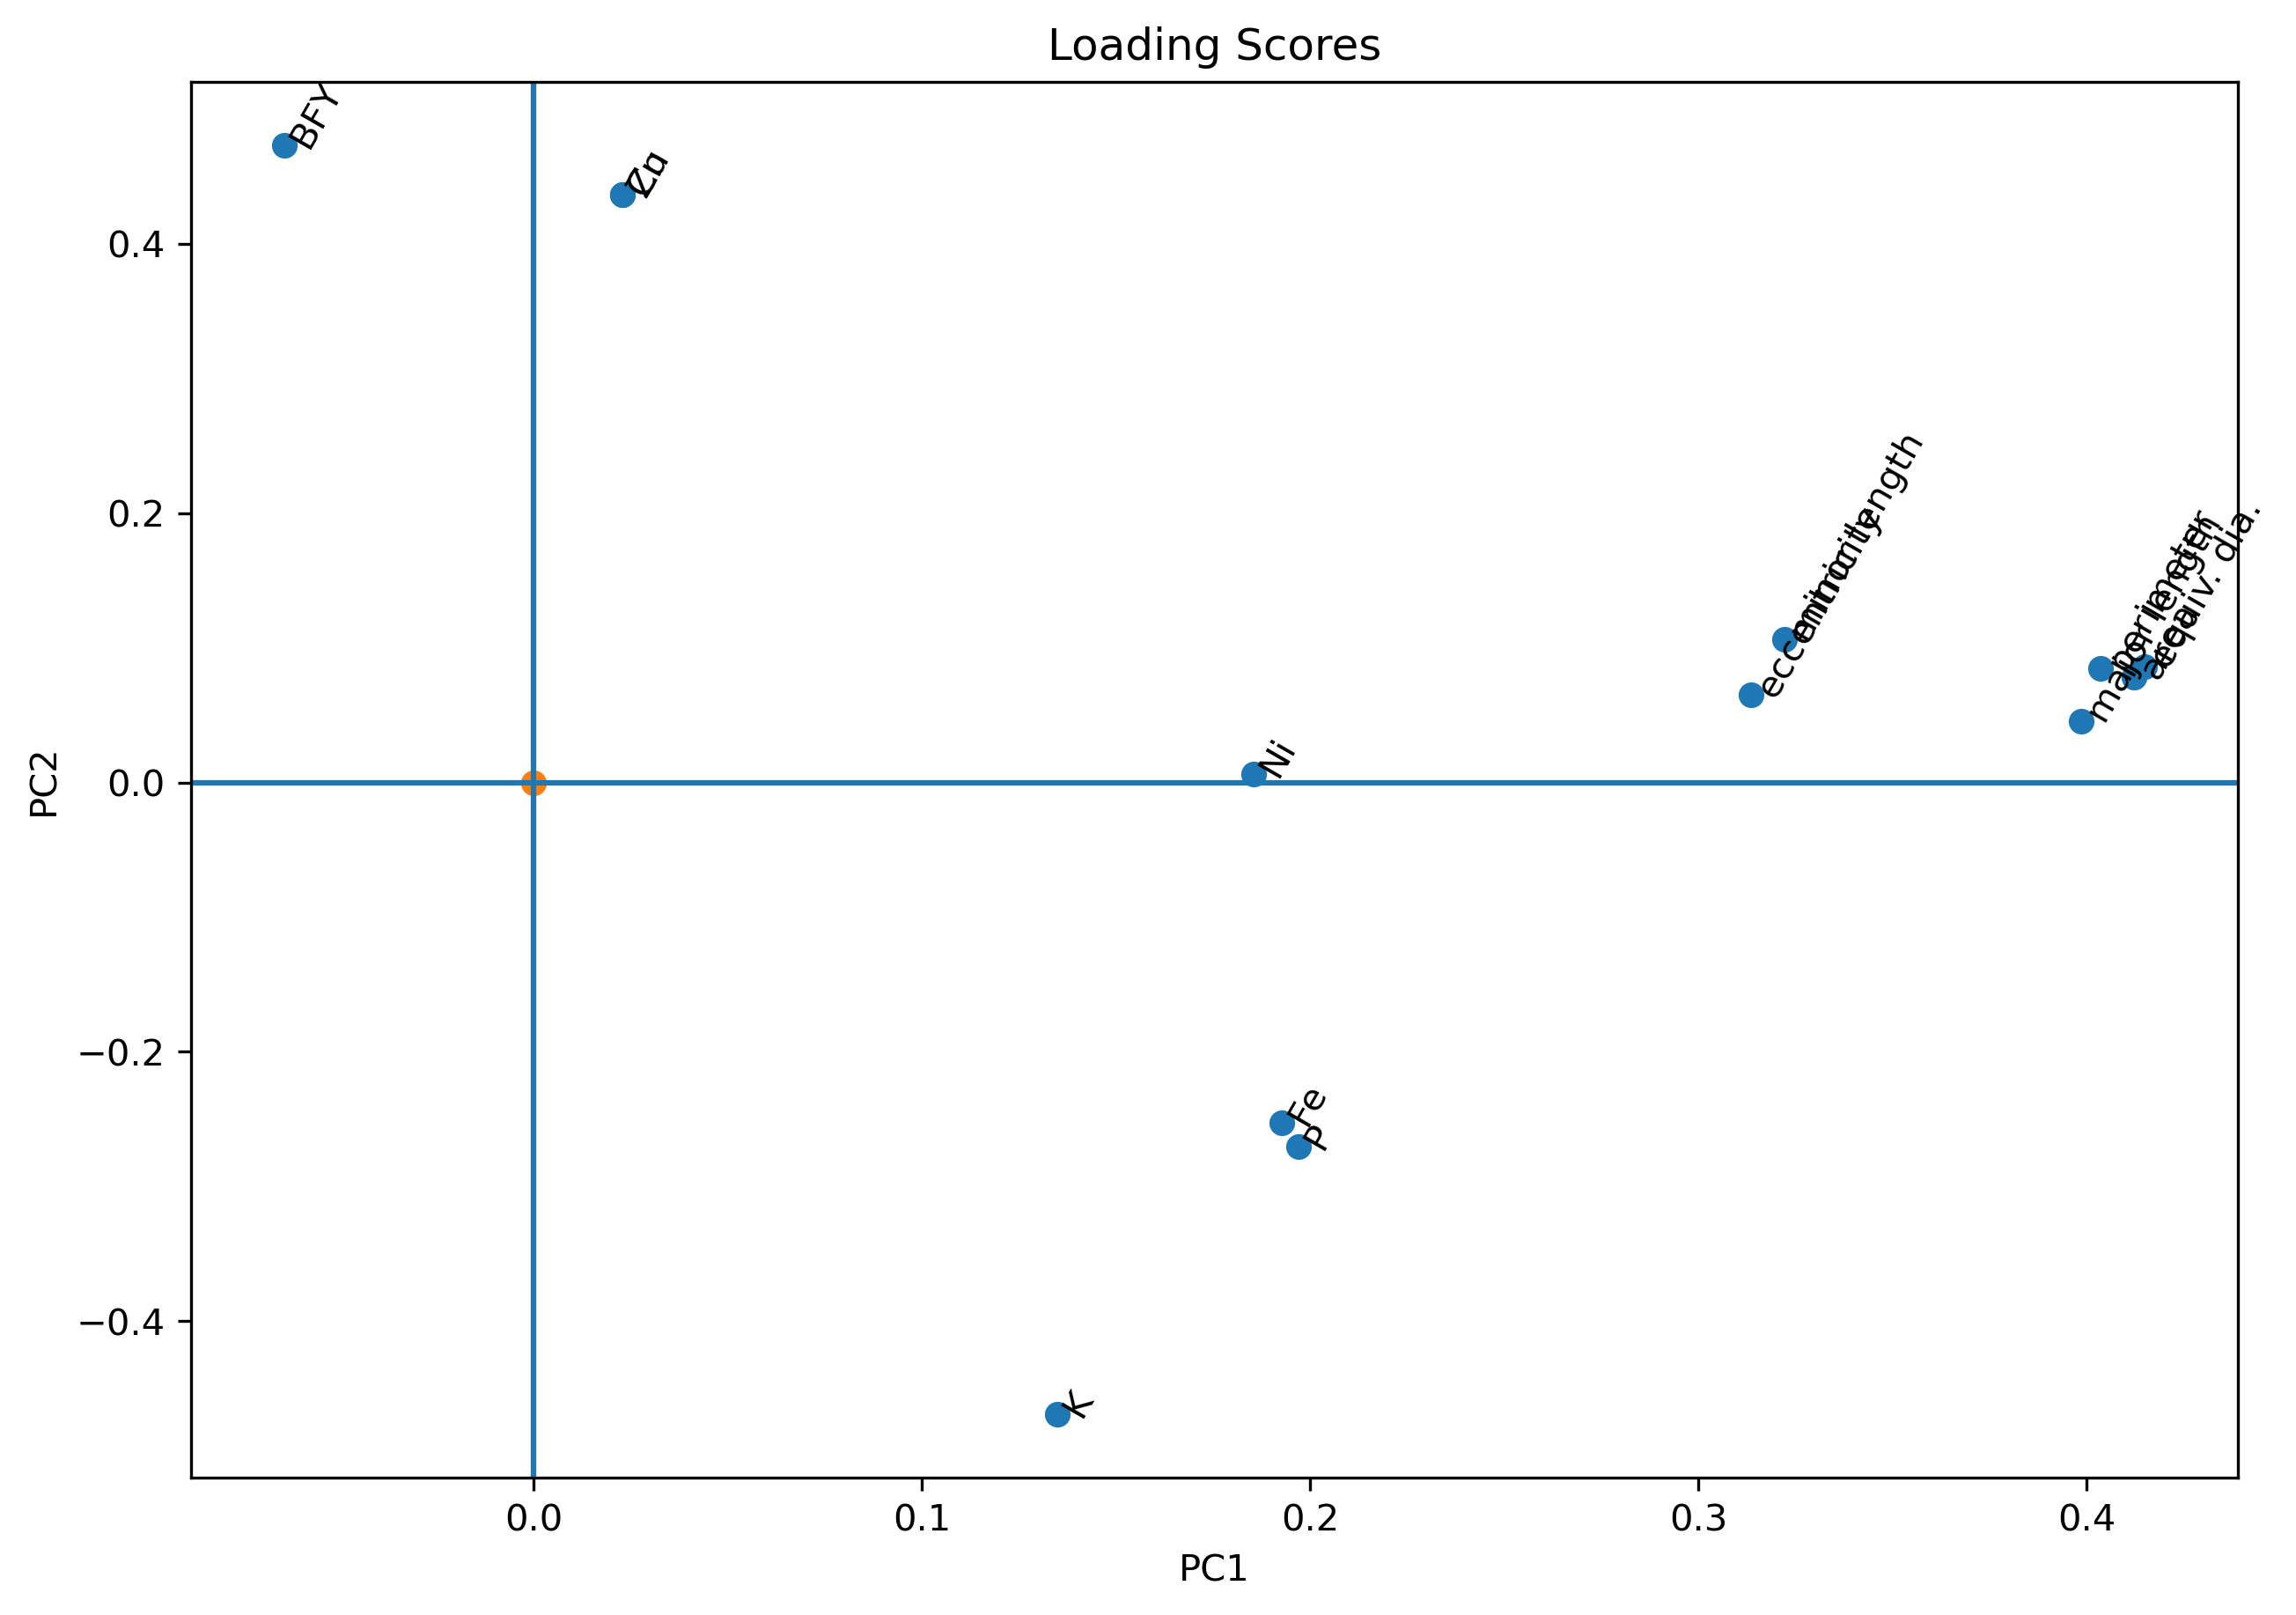

In [20]:
fig = plt.figure(figsize=(10,7),dpi=300);

plt.scatter(pca.components_[0],pca.components_[1]) #, tick_label=PClabels
plt.title('Loading Scores')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline()
plt.axvline()

names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ni','Zn',
         'Fe','Cu', 'BFY']

for i, txt in enumerate(names):
    plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]), rotation=60, size=10)

plt.scatter(0,0)
plt.show()


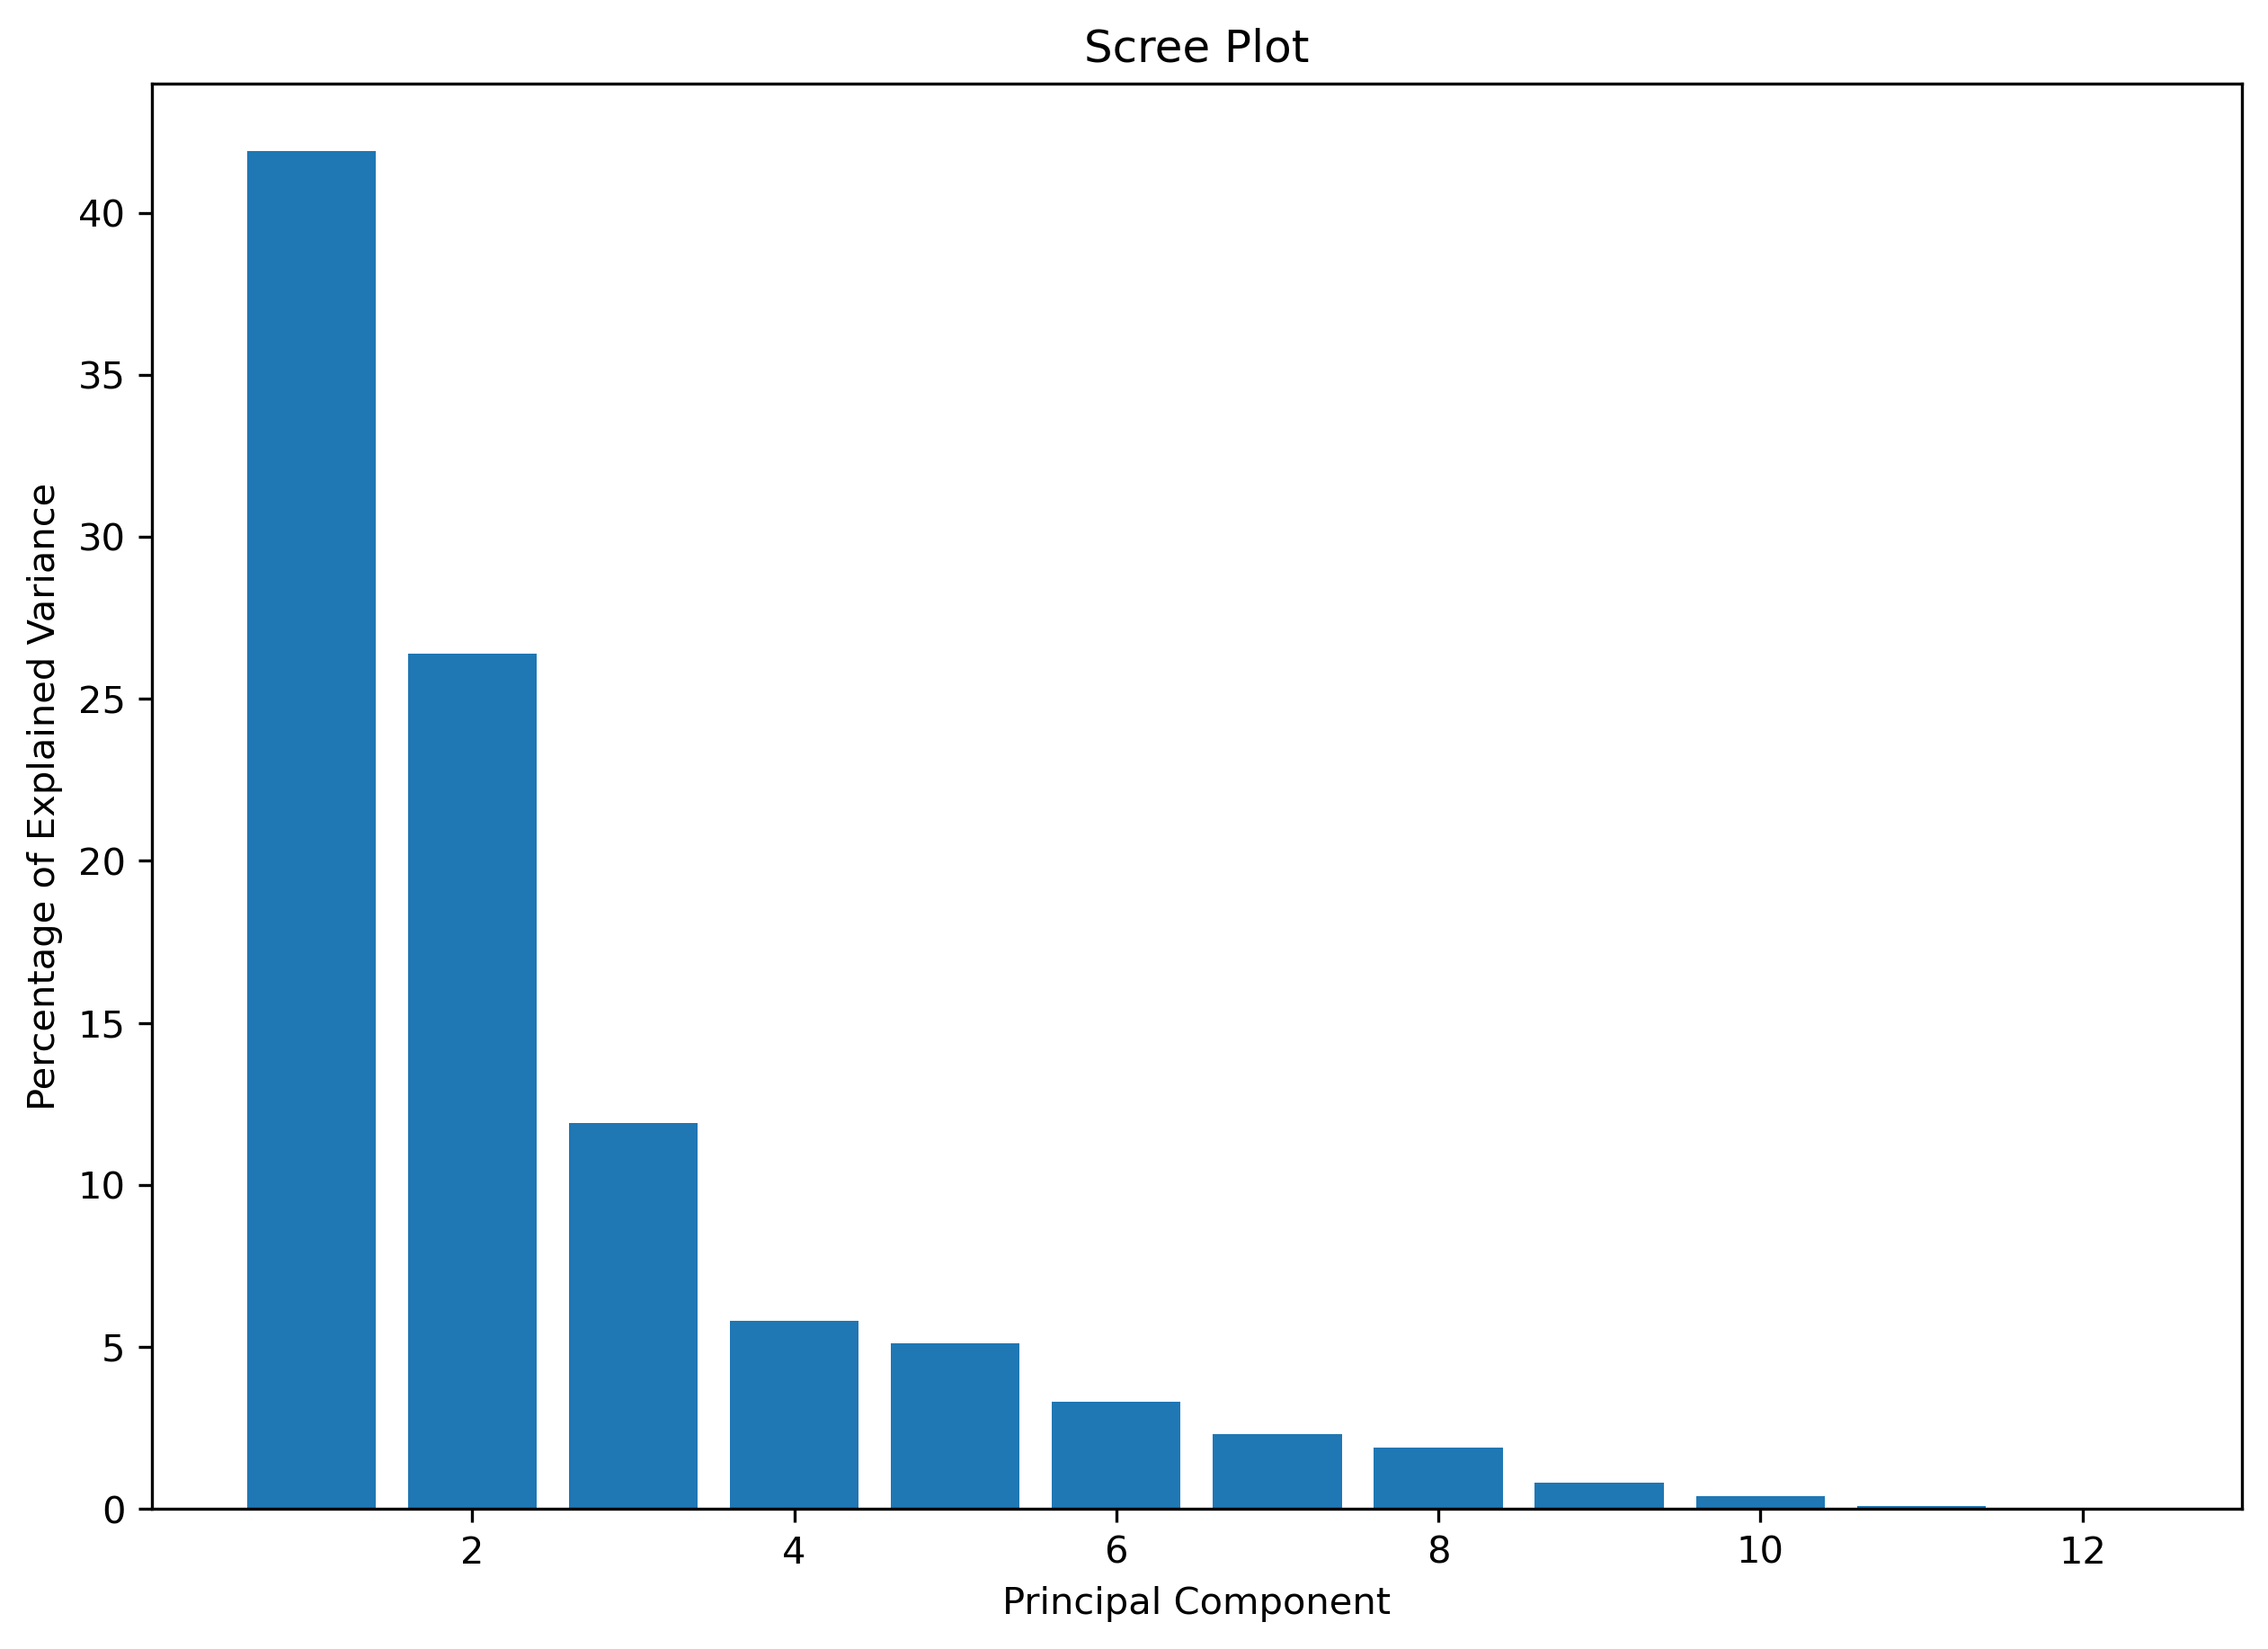

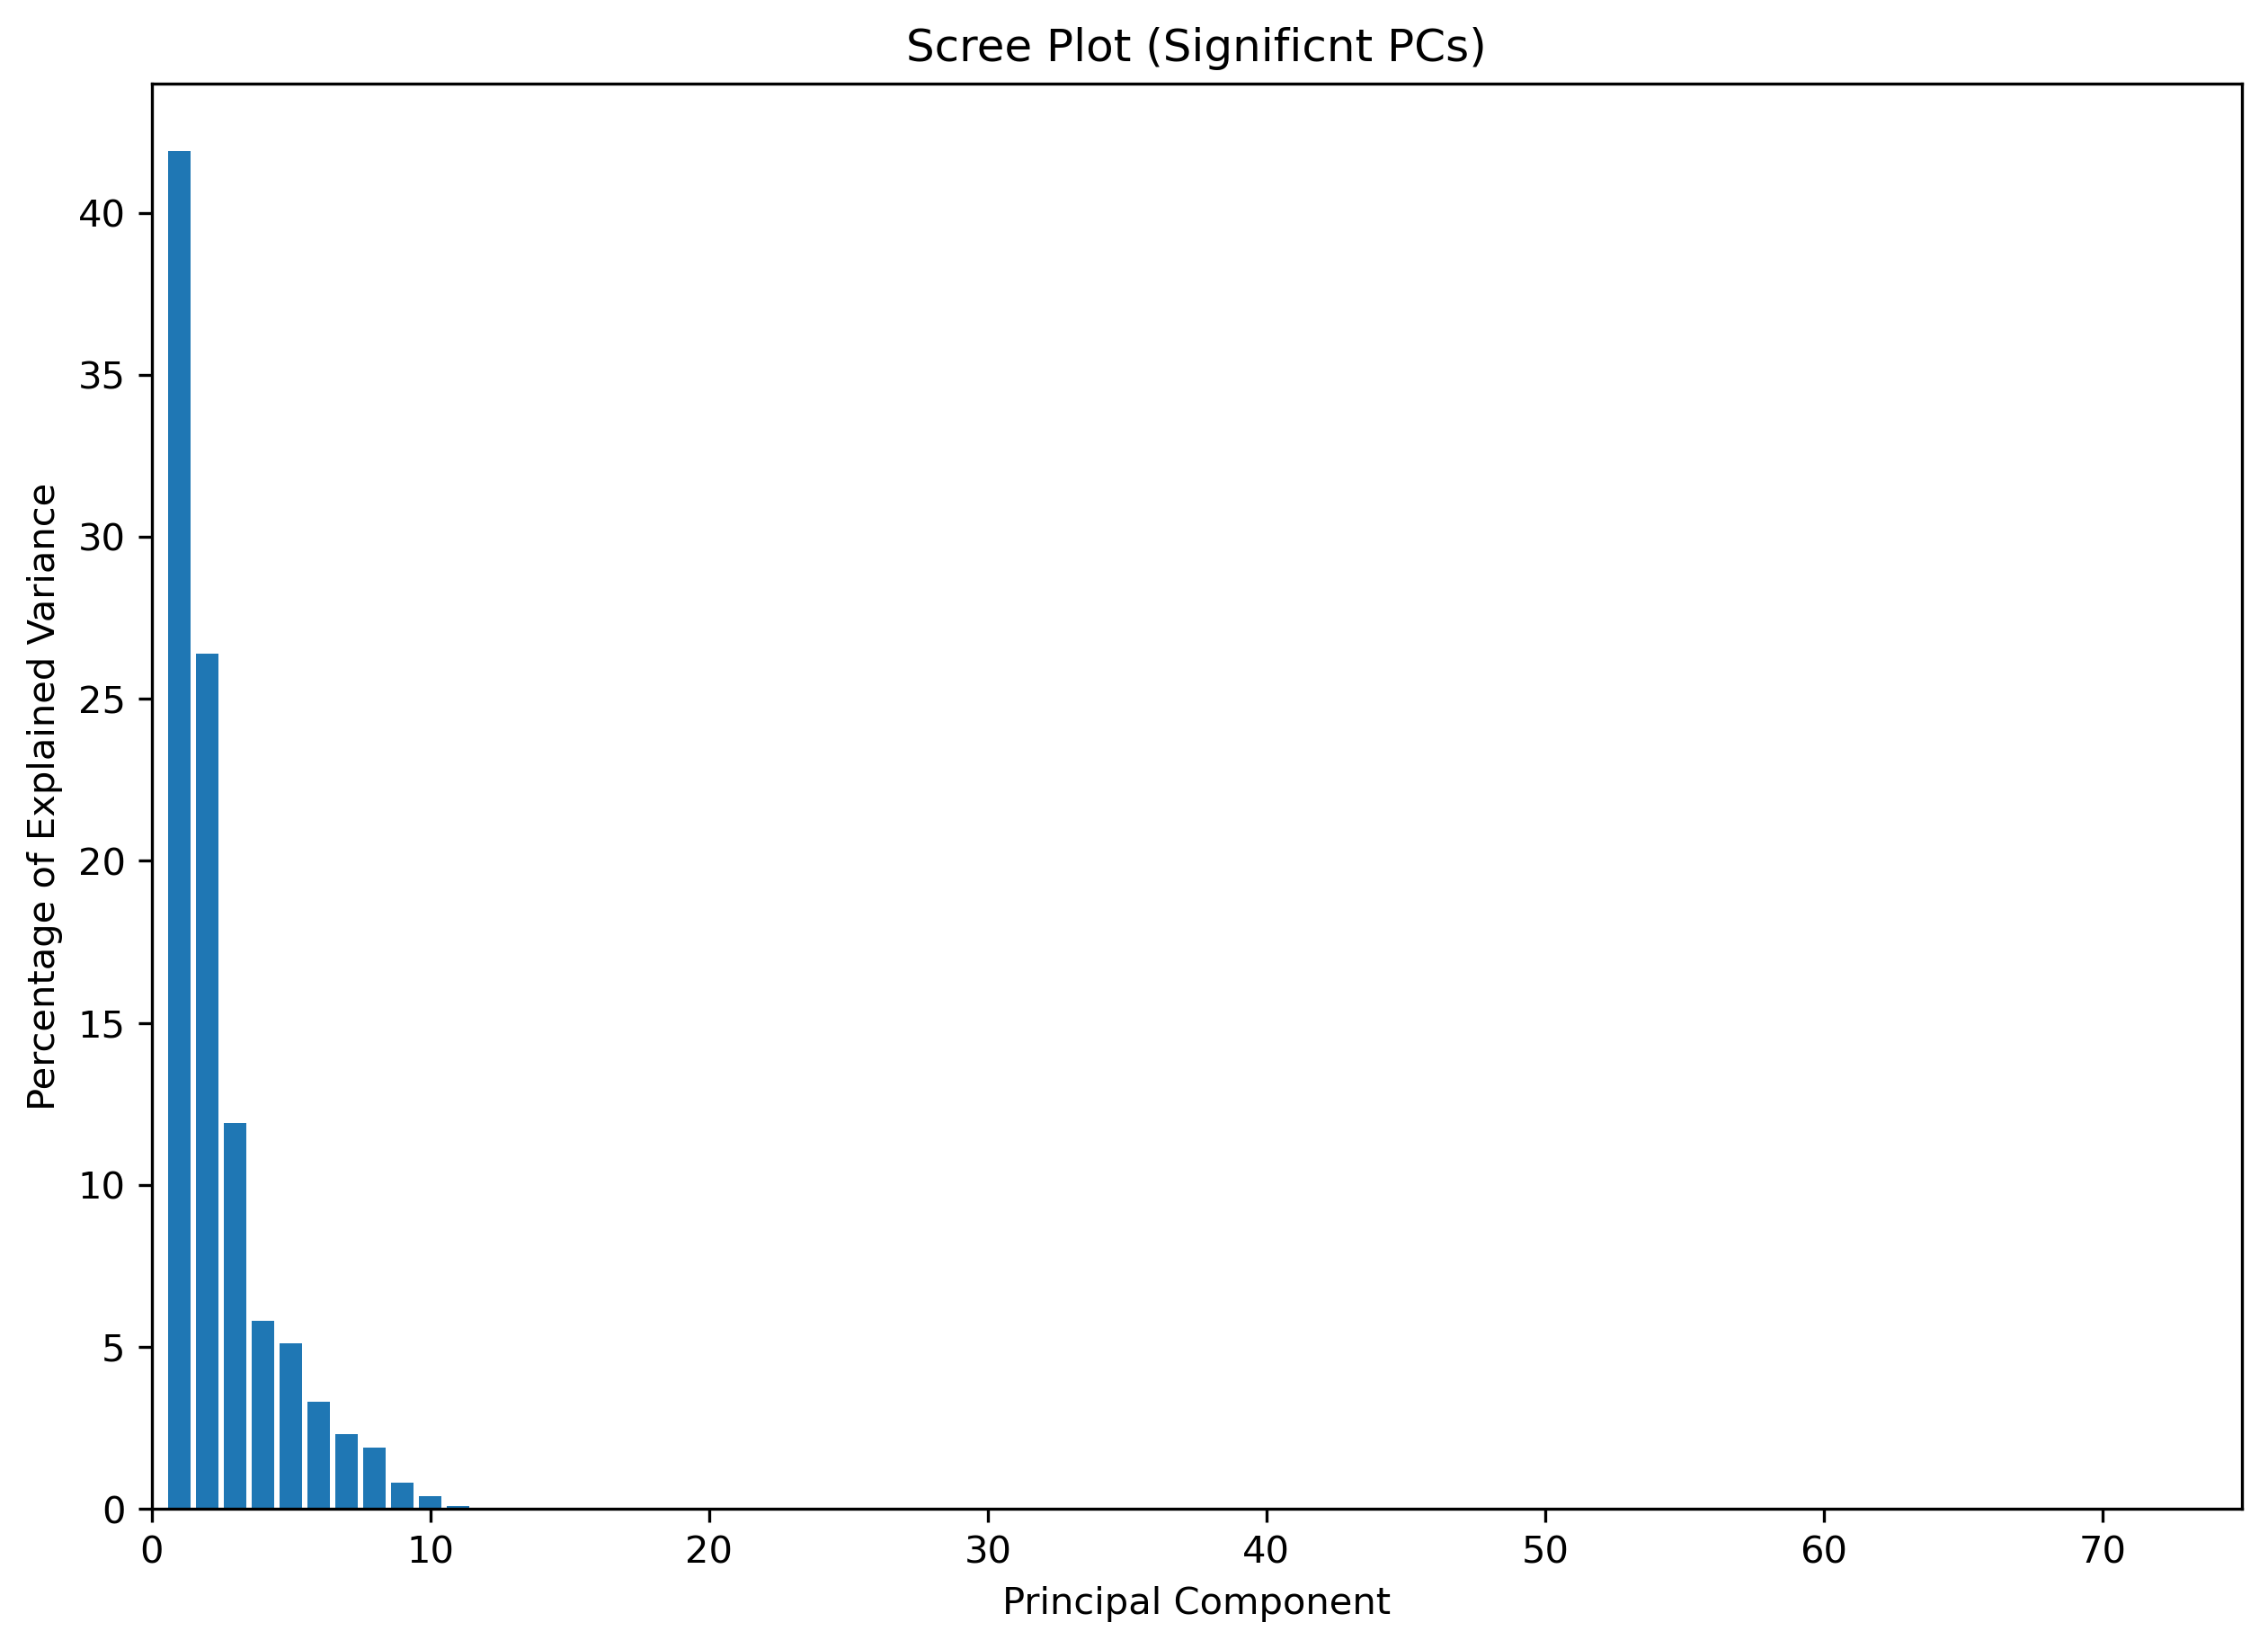

In [21]:
# get scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

In [22]:
principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Zn'] = X[:,9]
principalDf['Fe'] = X[:,10]
principalDf['Cu'] = X[:,11]
principalDf['BFY'] = X[:,12]

In [23]:
print(principalDf['area'].max())
print(principalDf['eccentricity'].max())
print(principalDf['equivalent_diameter'].max())
print(principalDf['major_axis_length'].max())
print(principalDf['minor_axis_length'].max())
print(principalDf['perimeter'] .max())
print(principalDf['K'].max())
print(principalDf['P'].max()) 
print(principalDf['Ni'].max()) 
print(principalDf['Zn'].max()) 
print(principalDf['Fe'].max()) 
print(principalDf['Cu'].max()) 
print(principalDf['BFY'].max()) 

4.125
0.9769395940802652
2.2917489221187703
4.373612352851659
2.4812696957111178
10.321067811865476
0.0008107276516966522
0.0003068469522986561
0.00012132191477576271
0.008068055845797062
0.000182758885785006
0.008068055845797062
0.025465836748480797


In [24]:
print(principalDf['area'].median())
print(principalDf['eccentricity'].median())
print(principalDf['equivalent_diameter'].median())
print(principalDf['major_axis_length'].median())
print(principalDf['minor_axis_length'].median())
print(principalDf['perimeter'] .median())
print(principalDf['K'].median())
print(principalDf['P'].median()) 
print(principalDf['Ni'].median()) 
print(principalDf['Zn'].median()) 
print(principalDf['Fe'].median()) 
print(principalDf['Cu'].median()) 
print(principalDf['BFY'].median()) 

0.6875
0.7559289460184544
0.9356025796273888
1.1281521496355325
0.7371064447728443
2.414213562373095
4.2070010749739595e-05
4.344635453890078e-05
4.0804767195368186e-05
0.0009462687594350427
6.080284765630495e-05
0.0009462687594350427
0.01471087895333767


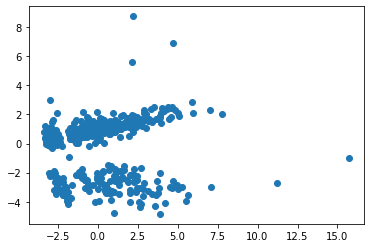

In [25]:
plt.scatter(principalDf['PC1'],principalDf['PC2'])

In [26]:
# now create mult label data frame with strict conditions

labels = [0] * X.shape[0]


# the artifact criterion Group 0

True_list = principalDf.loc[
    (principalDf['eccentricity'] == 0)
    
   ].index.tolist()

print( len(True_list) )
principalDf['text_labels'] = labels

for idx in True_list:
    labels[idx]='Group 0: Artifact, e = 0'

# Group 1
True_list = principalDf.loc[
    (principalDf['eccentricity'] > 0) &
    (principalDf['eccentricity'] <= 0.7)
    
   ].index.tolist()
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 1: e <0.7'
    
# Group 2 (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=principalDf['K'].median()) &
    (principalDf['K']/principalDf['P']>=(principalDf['K']/principalDf['P']).median())
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 2: Shape + Live'
    
# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=0.25*principalDf['Ni'].median()) &
    (principalDf['Ni']/principalDf['P']>= 0.25*(principalDf['Ni']/principalDf['P']).median()) &
    (principalDf['Ni']/principalDf['Zn']>= 0.25*(principalDf['Ni']/principalDf['Zn']).median()) &
    (principalDf['Ni']/principalDf['Fe']>= 0.25*(principalDf['Ni']/principalDf['Fe']).median()) &
    (principalDf['Ni']/principalDf['K']>= 0.25*(principalDf['Ni']/principalDf['K']).median()) &
    (principalDf['Cu']/principalDf['K']>= 0.25*(principalDf['Cu']/principalDf['K']).median())
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='Group 3: Shape + Dead' 
    

    
    
# the eccentricity criterion

# True_list = principalDf.loc[
#     (principalDf['eccentricity'] >= 0.5) &
#     (principalDf['eccentricity'] <= 0.6) &
#     (principalDf['major_axis_length']<= 0.875)
#    ].index.tolist()

# print( len(True_list) )

# for idx in True_list:
#     labels[idx]='Group 4: 0.5 <= e <=0.6, l<=0.975'
    

for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'Group 4: outlier/undetermined'
    
principalDf['text_labels'] = labels


132
114
128
245


In [27]:
(principalDf['K']/principalDf['P']).median()

1.115593513658345

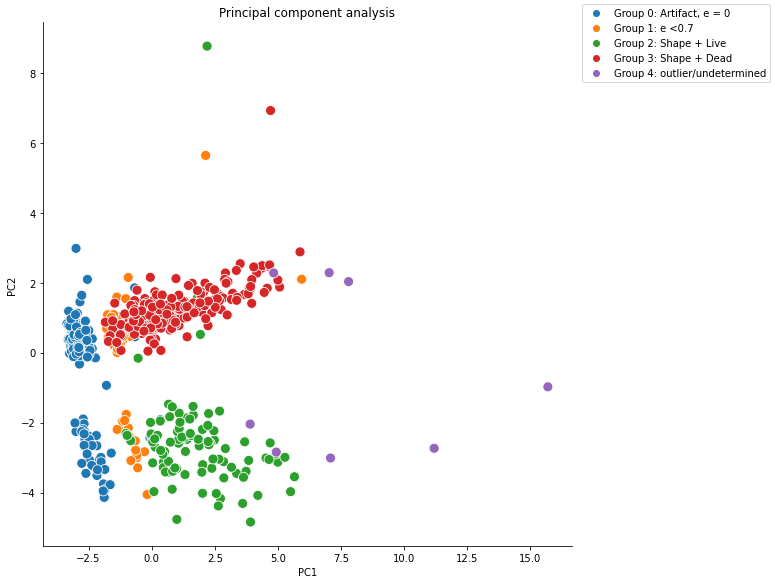

In [28]:
pp = sns.pairplot(data=principalDf.sort_values(by = 'text_labels'),
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [29]:
# now create mult label data frame with strict conditions

labels = [0] * X.shape[0]
#create numerical labels

# Group 1 (artifacts)

for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'artifacts/background/outlier'

    
# Group 2 (live)
K_threshold=4.2e-05 #default is median
KbyP_threshold=1 #default is median
True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['K']>=principalDf['K'].median()) &
    (principalDf['K']/principalDf['P']>=(principalDf['K']/principalDf['P']).median())
   ].index.tolist()

print( len(True_list) )

for idx in True_list:
    labels[idx]='live cells'
    
# Group 3 (Dead)
Ni_threshold=2.04e-05 #default is half of median
NibyP_threshold=0.48 #default is half of median

NibyZn_threshold=0.021 #default is half of median
NibyFe_threshold=0.32 #default is half of median
NibyK_threshold=0.485 #default is half of median
CubyK_threshold=13 #default is half of median

True_list = principalDf.loc[
    (principalDf['major_axis_length']>=1) & 
    (principalDf['major_axis_length']<= 3) &
    (principalDf['minor_axis_length']>=0.5) & 
    (principalDf['minor_axis_length']<= 1.5) &
    (principalDf['Ni']>=0.25*principalDf['Ni'].median()) &
    (principalDf['Ni']/principalDf['P']>= 0.25*(principalDf['Ni']/principalDf['P']).median()) &
    (principalDf['Ni']/principalDf['Zn']>= 0.25*(principalDf['Ni']/principalDf['Zn']).median()) &
    (principalDf['Ni']/principalDf['Fe']>= 0.25*(principalDf['Ni']/principalDf['Fe']).median()) &
    (principalDf['Ni']/principalDf['K']>= 0.25*(principalDf['Ni']/principalDf['K']).median()) &
    (principalDf['Cu']/principalDf['K']>= 0.25*(principalDf['Cu']/principalDf['K']).median())
   ].index.tolist()    
    
print( len(True_list) )

for idx in True_list:
    labels[idx]='dead cells' 
    


    
principalDf['text_labels'] = labels


128
245


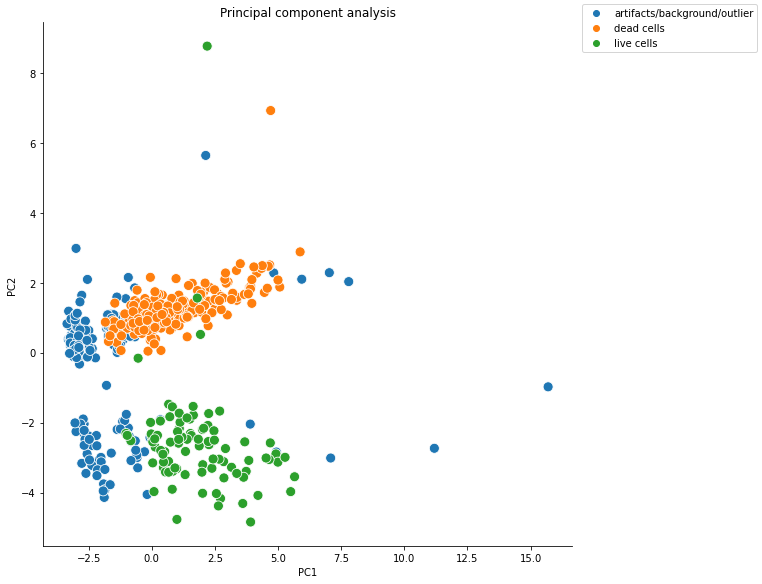

In [30]:
pp = sns.pairplot(data=principalDf.sort_values(by = 'text_labels'),
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis')



In [31]:
principalDf

,PC1,PC2,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,text_labels
0,-2.963312,0.271561,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000029,0.001002,0.000071,0.001002,0.015246,artifacts/background/outlier
1,-2.886770,0.146646,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000029,0.000030,0.000043,0.000768,0.000062,0.000768,0.015790,artifacts/background/outlier
2,-2.564881,0.349637,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000030,0.000045,0.000043,0.001093,0.000095,0.001093,0.018312,artifacts/background/outlier
3,2.740350,1.607484,1.3125,0.846038,1.292721,1.764861,0.940886,3.828427,0.000045,0.000083,0.000058,0.001371,0.000059,0.001371,0.016610,dead cells
4,1.330496,1.099449,1.0625,0.945978,1.163107,2.102629,0.681738,2.267767,0.000045,0.000041,0.000055,0.001019,0.000076,0.001019,0.017674,dead cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,4.917267,-2.896002,1.5625,0.941817,1.410474,2.474690,0.831810,5.035534,0.000437,0.000122,0.000056,0.000059,0.000095,0.000059,0.005291,live cells
550,15.693342,-0.978194,4.1250,0.780748,2.291749,3.971010,2.481270,10.321068,0.000446,0.000147,0.000066,0.000099,0.000125,0.000099,0.005216,artifacts/background/outlier
551,0.460987,-3.287474,0.6875,0.819334,0.935603,1.241999,0.712058,2.267767,0.000449,0.000102,0.000034,0.000064,0.000068,0.000064,0.004908,live cells
552,-1.855388,-3.919492,0.3125,0.000000,0.630783,0.632456,0.632456,1.414214,0.000313,0.000101,0.000029,0.000031,0.000116,0.000031,0.004815,artifacts/background/outlier


In [32]:
num_labels = [0] * X.shape[0]
for idx, value in enumerate(labels):
    if value == 'live cells':
        num_labels[idx]=1
    if value == 'dead cells':
        num_labels[idx]=2
        
CAE_labels=np.array(num_labels)

In [33]:
CAE_labels=np.array(num_labels)

In [34]:
print(X_bin.shape)

(554, 32, 32)


In [35]:
print(CAE_labels.shape)

(554,)


In [36]:
#Adding VAE

# INITIALIZERS

BASE_PATCH_WIDTH=32  #Width of the cell (pixels)

latent_dim=4

num_channels = 1

cell_types=2
noise_amplitude=0.000
        
encoder,decoder=autoencoder_32.autoencoder(latent_dim,num_channels,BASE_PATCH_WIDTH,summary='yes')



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 4096)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

2022-02-24 13:08:10.330065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 13:08:10.335817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2022-02-24 13:08:10.342288: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-02-24 13:08:10.343207: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-24 13:08:11.406520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect Str

In [37]:
# vae = Short_VAE(encoder, decoder,weight=1/250,regularization_type='L1',recon_type='bce')
vae = autoencoder_32.Short_VAE(encoder, decoder,weight=1/2,regularization_type='kl',recon_type='bce')

vae.compile(optimizer='adam')


In [38]:
# class Sampling(layers.Layer):
#     """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

#     def call(self, inputs):
#         z_mean, z_log_var = inputs
#         batch = tf.shape(z_mean)[0]
#         dim = tf.shape(z_mean)[1]
#         epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
#         return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    
# latent_dim = 16

# encoder_inputs = keras.Input(shape=(32, 32, 1))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
# x = layers.Dense(16, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

# latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((8, 8, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
# decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

In [39]:
# class VAE(keras.Model):
#     def __init__(self, encoder, decoder, **kwargs):
#         super(VAE, self).__init__(**kwargs)
#         self.encoder = encoder
#         self.decoder = decoder
#         self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
#         self.reconstruction_loss_tracker = keras.metrics.Mean(
#             name="reconstruction_loss"
#         )
#         self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

#     @property
#     def metrics(self):
#         return [
#             self.total_loss_tracker,
#             self.reconstruction_loss_tracker,
#             self.kl_loss_tracker,
#         ]

#     def train_step(self, data):
#         with tf.GradientTape() as tape:
#             z_mean, z_log_var, z = self.encoder(data)
#             reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
#             kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
#             total_loss = reconstruction_loss + kl_loss
#         grads = tape.gradient(total_loss, self.trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
#         self.total_loss_tracker.update_state(total_loss)
#         self.reconstruction_loss_tracker.update_state(reconstruction_loss)
#         self.kl_loss_tracker.update_state(kl_loss)
#         return {
#             "loss": self.total_loss_tracker.result(),
#             "reconstruction_loss": self.reconstruction_loss_tracker.result(),
#             "kl_loss": self.kl_loss_tracker.result(),
#         }

In [40]:

img_data=X_bin

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    img_data, CAE_labels, test_size=0.3, random_state=786)

img_data = np.expand_dims(img_data, -1).astype("int")
# img_data = np.expand_dims(img_data, -1).astype("float32") / 255

In [41]:


# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())
# vae.fit(img_data, epochs=30, batch_size=128)

In [42]:
vae_one_channel=vae.fit(img_data, epochs=100, batch_size=128,verbose=True)  


2022-02-24 13:08:14.629205: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-24 13:08:14.650456: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000000000 Hz


Epoch 1/100


2022-02-24 13:08:15.254584: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-02-24 13:08:15.602869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-02-24 13:08:16.018603: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-24 13:08:16.837226: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


5/5 [==============================] - 2s 23ms/step - loss: 0.0947 - reconstruction_loss: 0.0677 - regularization_loss: 0.0475
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0853 - reconstruction_loss: 0.0654 - regularization_loss: 0.0377
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0763 - reconstruction_loss: 0.0553 - regularization_loss: 0.0389
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0667 - reconstruction_loss: 0.0463 - regularization_loss: 0.0376
Epoch 5/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0509 - reconstruction_loss: 0.0352 - regularization_loss: 0.0264
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0389 - reconstruction_loss: 0.0315 - regularization_loss: 0.0121
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0296 - reconstruction_loss: 0.0231 - regularization_loss: 0.0109
Epoch 8/100
5/5 [===========================

5/5 [==============================] - 0s 10ms/step - loss: 0.0177 - reconstruction_loss: 0.0144 - regularization_loss: 0.0067
Epoch 60/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0175 - reconstruction_loss: 0.0151 - regularization_loss: 0.0059
Epoch 61/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0178 - reconstruction_loss: 0.0149 - regularization_loss: 0.0058
Epoch 62/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0185 - reconstruction_loss: 0.0142 - regularization_loss: 0.0072
Epoch 63/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0173 - reconstruction_loss: 0.0144 - regularization_loss: 0.0063
Epoch 64/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0181 - reconstruction_loss: 0.0155 - regularization_loss: 0.0054
Epoch 65/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0167 - reconstruction_loss: 0.0139 - regularization_loss: 0.0065
Epoch 66/100
5/5 [==================

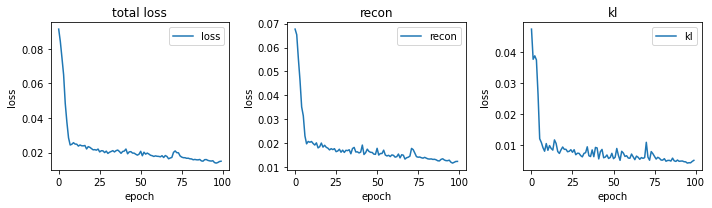

In [43]:
autoencoder_32.model_history(vae_one_channel,'kl')

In [44]:
from ipywidgets import interactive
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def viewer(index):
    check_VAE_output(x_train,index,BASE_PATCH_WIDTH,encoder,decoder)


interactive_image = interactive(viewer, index = (0,x_train.shape[0]-1))
output = interactive_image.children[-1]
# output.layout.height = '300px'
interactive_image

interactive(children=(IntSlider(value=193, description='index', max=386), Output()), _dom_classes=('widget-int…

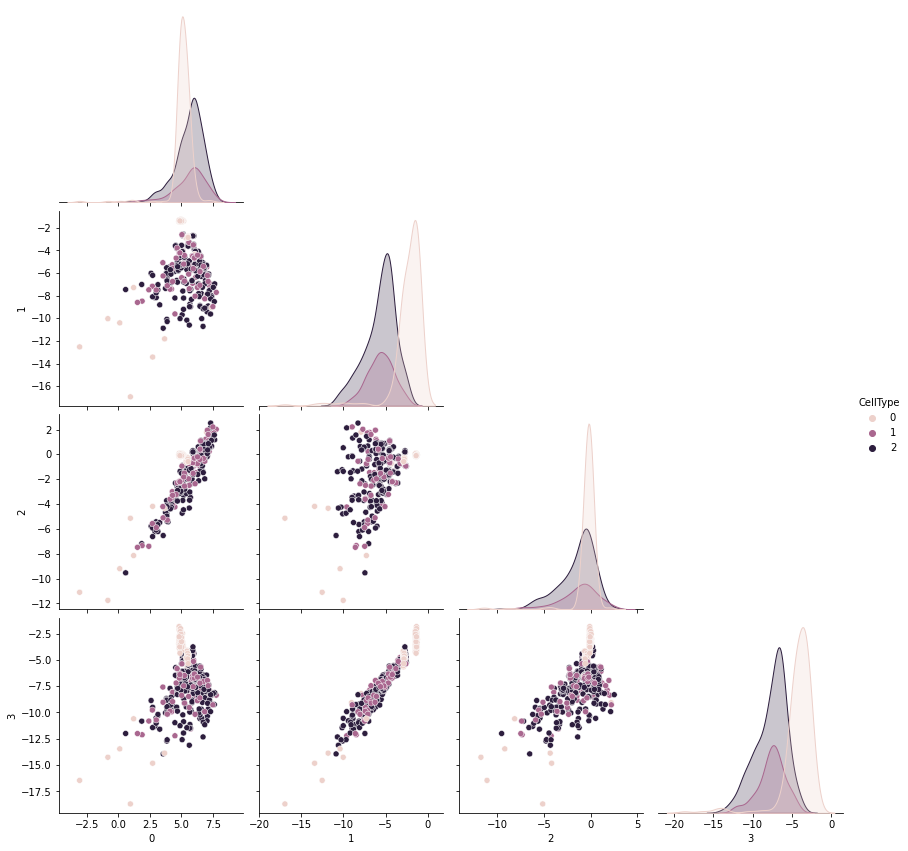

In [45]:
autoencoder_32.view_latent_variable_clusters(img_data,CAE_labels,cell_types,encoder,pairplot_height=3,PCA_flag='no',
    PCA_figwidth=8)  

In [46]:
# def plot_latent_space(vae, n=30, figsize=15):
#     # display a n*n 2D manifold of digits
#     digit_size = 32
#     scale = 1.0
#     figure = np.zeros((digit_size * n, digit_size * n))
#     # linearly spaced coordinates corresponding to the 2D plot
#     # of digit classes in the latent space
#     grid_x = np.linspace(-scale, scale, n)
#     grid_y = np.linspace(-scale, scale, n)[::-1]

#     for i, yi in enumerate(grid_y):
#         for j, xi in enumerate(grid_x):
#             z_sample = np.array([[xi, yi]])
#             x_decoded = vae.decoder.predict(z_sample)
#             digit = x_decoded[0].reshape(digit_size, digit_size)
#             figure[
#                 i * digit_size : (i + 1) * digit_size,
#                 j * digit_size : (j + 1) * digit_size,
#             ] = digit

#     plt.figure(figsize=(figsize, figsize))
#     start_range = digit_size // 2
#     end_range = n * digit_size + start_range
#     pixel_range = np.arange(start_range, end_range, digit_size)
#     sample_range_x = np.round(grid_x, 1)
#     sample_range_y = np.round(grid_y, 1)
#     plt.xticks(pixel_range, sample_range_x)
#     plt.yticks(pixel_range, sample_range_y)
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.imshow(figure, cmap="Greys_r")
#     plt.show()


# plot_latent_space(vae)

In [47]:
# def plot_label_clusters(vae, data, labels):
#     # display a 2D plot of the digit classes in the latent space
#     z_mean, _, _ = vae.encoder.predict(data)
#     plt.figure(figsize=(12, 10))
#     plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
#     plt.colorbar()
#     plt.xlabel("z[0]")
#     plt.ylabel("z[1]")
#     plt.show()


# x_train = np.expand_dims(x_train, -1).astype("float32") / 255

# plot_label_clusters(vae, x_train, y_train)

In [8]:
# load Z. Liu's data to get an idea about what it is

import config
from config import *
%matplotlib inline

#Assemble the data such that PCA can go and look through to learn something

filename = '/data02/AZC/BraggEmb/dataset/PeakInfo-feb21-000402.h5'
with h5py.File(filename, 'r') as dat:
            groups= list(dat.keys())
            print(groups)
            print(dat['patch'])
            print(dat['peakLoc'])
#             maps= list(dat['MAPS'].keys())
#             chs = dat['MAPS/channel_names'][:].astype(str).tolist()
#             dat['MAPS/']


['patch', 'peakLoc']
<HDF5 dataset "patch": shape (240073, 15, 15), type "<u2">
<HDF5 dataset "peakLoc": shape (240073,), type "|O">


In [ ]:
#end